<h4>Libs and housekeeping</h4>

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm

from sklearn.metrics import (mean_absolute_error, 
                            mean_squared_error,
                            mean_absolute_percentage_error)

In [3]:
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
rnd = np.random.RandomState(RANDOM_STATE)

NUM_SAMPLES = 600

params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1,
          'scatter.edgecolors': 'b' 
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid')

<Figure size 1500x700 with 0 Axes>

<H4>Helper function </H4>

In [5]:
def plotds(xt, nlag = 30, figsize = (15,12)):
    if not isinstance(xt, pd.Series):
            xt = pd.Series(xt)
        
    plt.figure(figsize = figsize)

    layout = (2,2)

    # assign Axis
    ax_xt = plt.subplot2grid(layout, (0,0), colspan=2)
    ax_acf = plt.subplot2grid(layout,(1,0))
    ax_pacf = plt.subplot2grid(layout,(1,1))
    
    xt.plot(ax=ax_xt)
    ax_xt.set_title('time Series')

    plot_acf(xt, lags=nlag, ax =ax_acf)
    plot_pacf(xt, lags=nlag, ax =ax_pacf)
    plt.tight_layout()

In [6]:
csvName='website_data.csv'
data_df=pd.read_csv(csvName)
data_df.head()

,traffic
0,932
1,929
2,938
3,964
4,990


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


In [8]:
data_df.describe()

,traffic
count,393.000000
mean,3046.516539
std,1198.711162
min,913.000000
25%,2039.000000
50%,2802.000000
75%,4355.000000
max,4941.000000


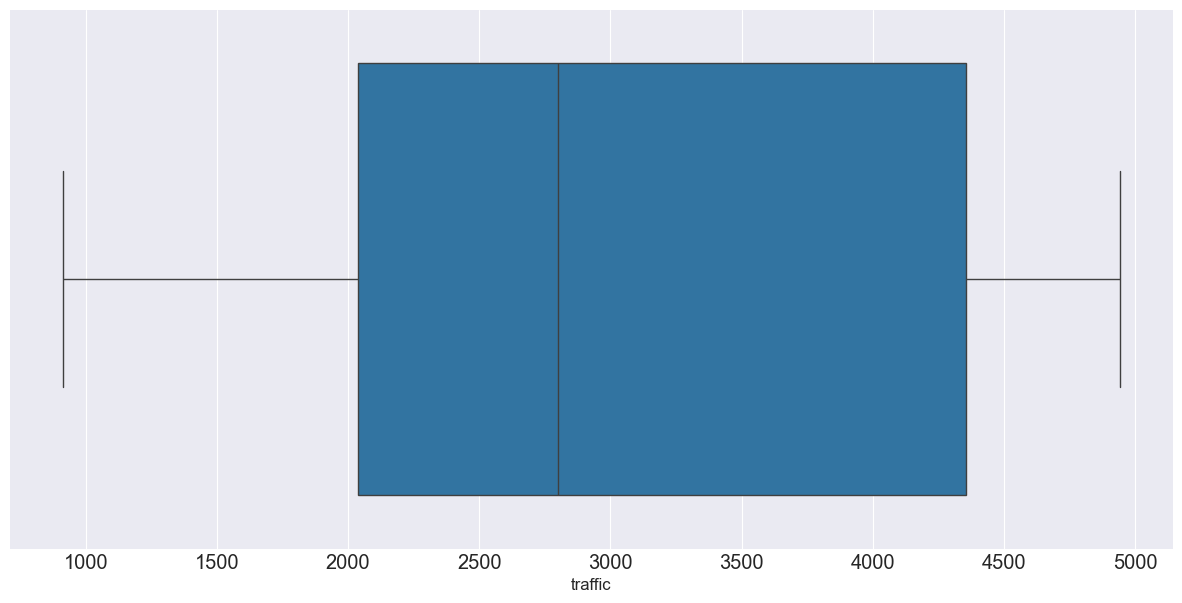

In [9]:
ax=sns.boxplot(data=data_df,x='traffic')

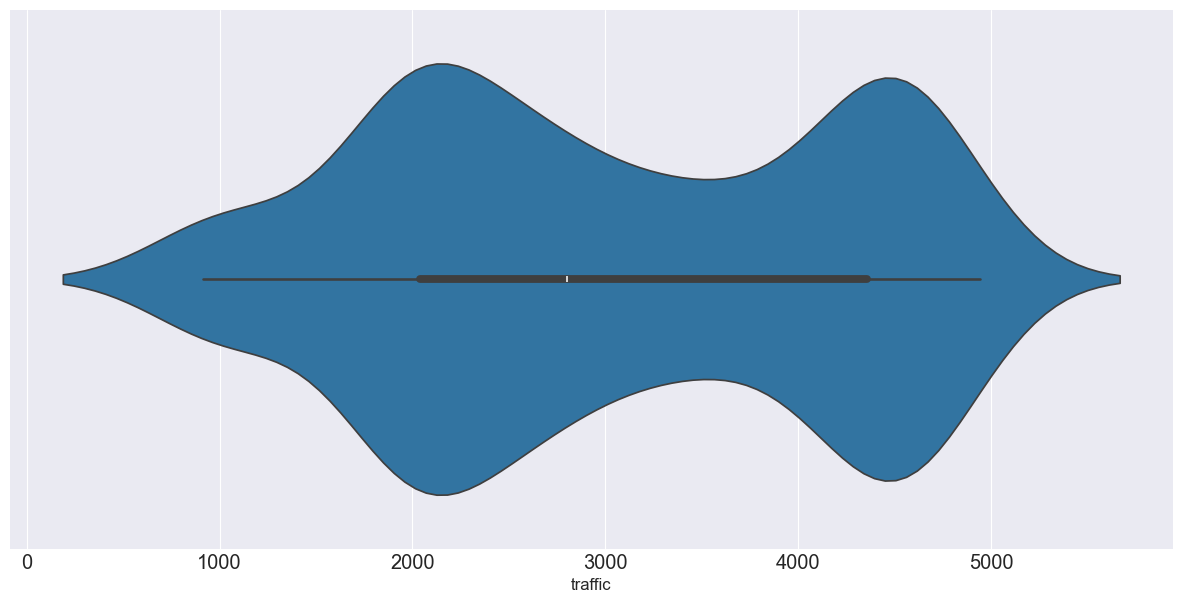

In [10]:
ax=sns.violinplot(data=data_df, x='traffic')

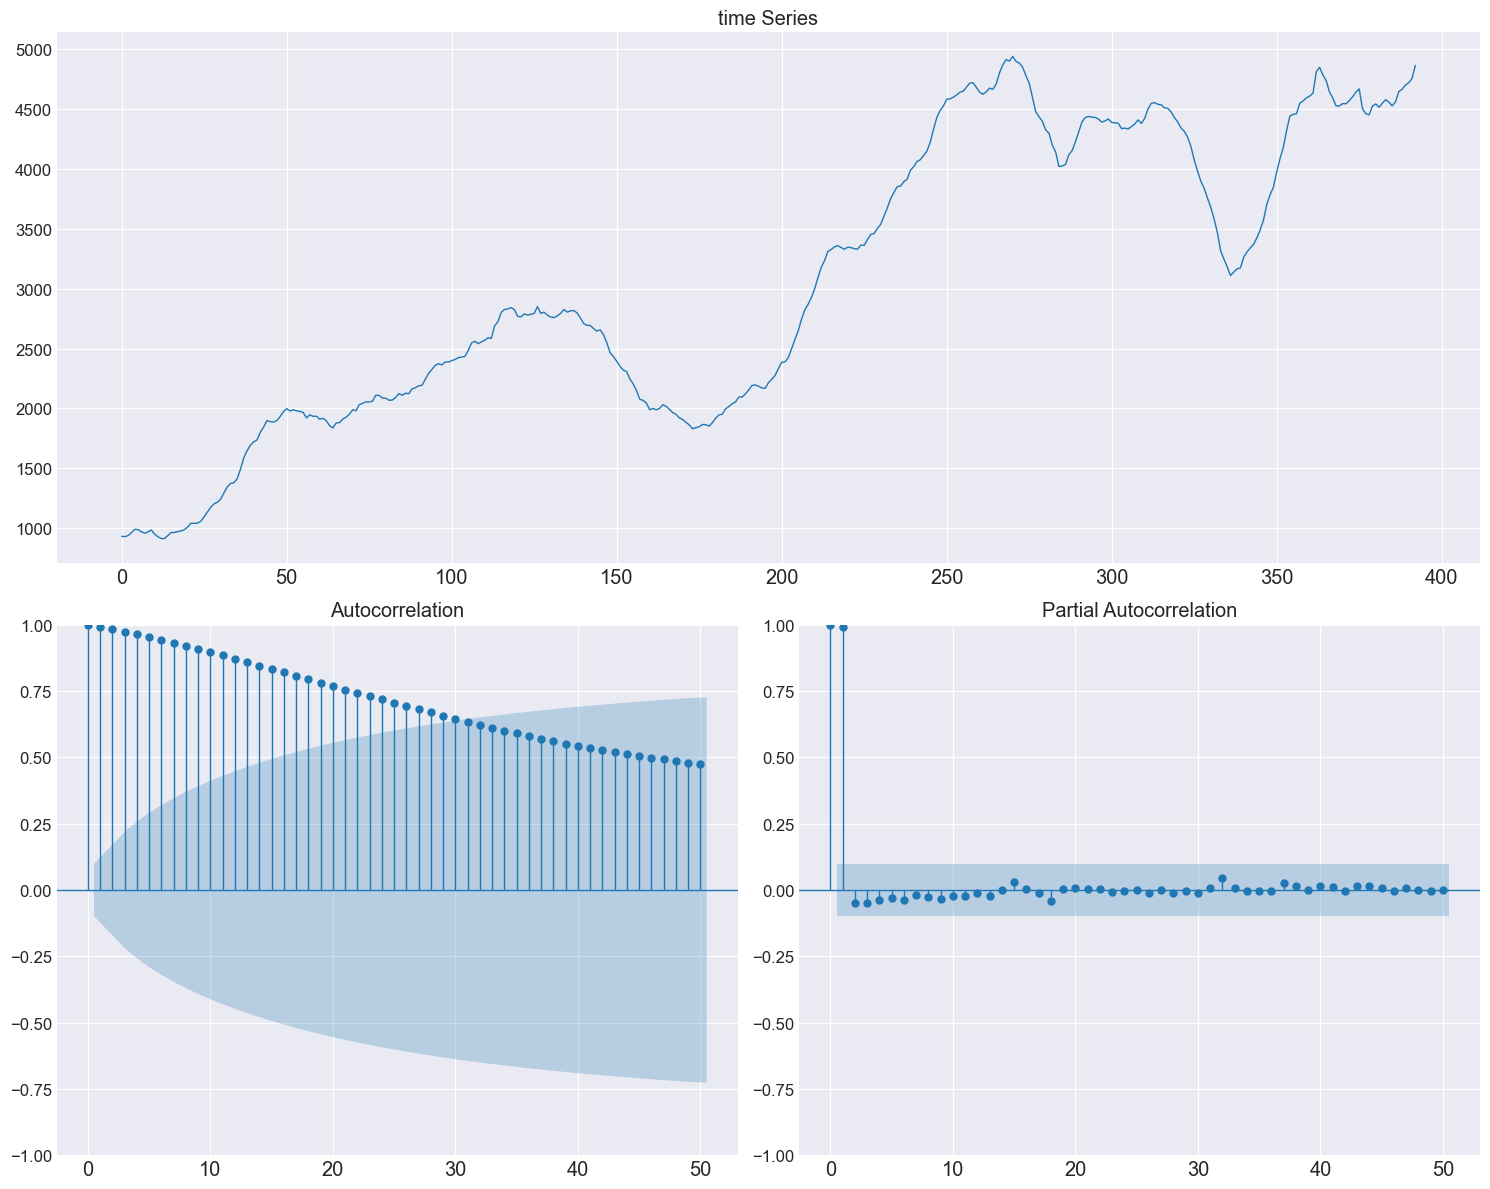

In [11]:
plotds(data_df.traffic,nlag=50)

In [12]:
train_df= data_df.iloc[:360]
test_df = data_df.iloc[360:]
train_df.shape, test_df.shape

((360, 1), (33, 1))

In [13]:
adfuller(train_df.to_numpy()) #>>> 0.5

(-1.4747100518772567,
 0.5459827686831111,
 16,
 343,
 {'1%': -3.449559661646851,
  '5%': -2.8700035112469626,
  '10%': -2.5712790073013796},
 3285.5167845180695)

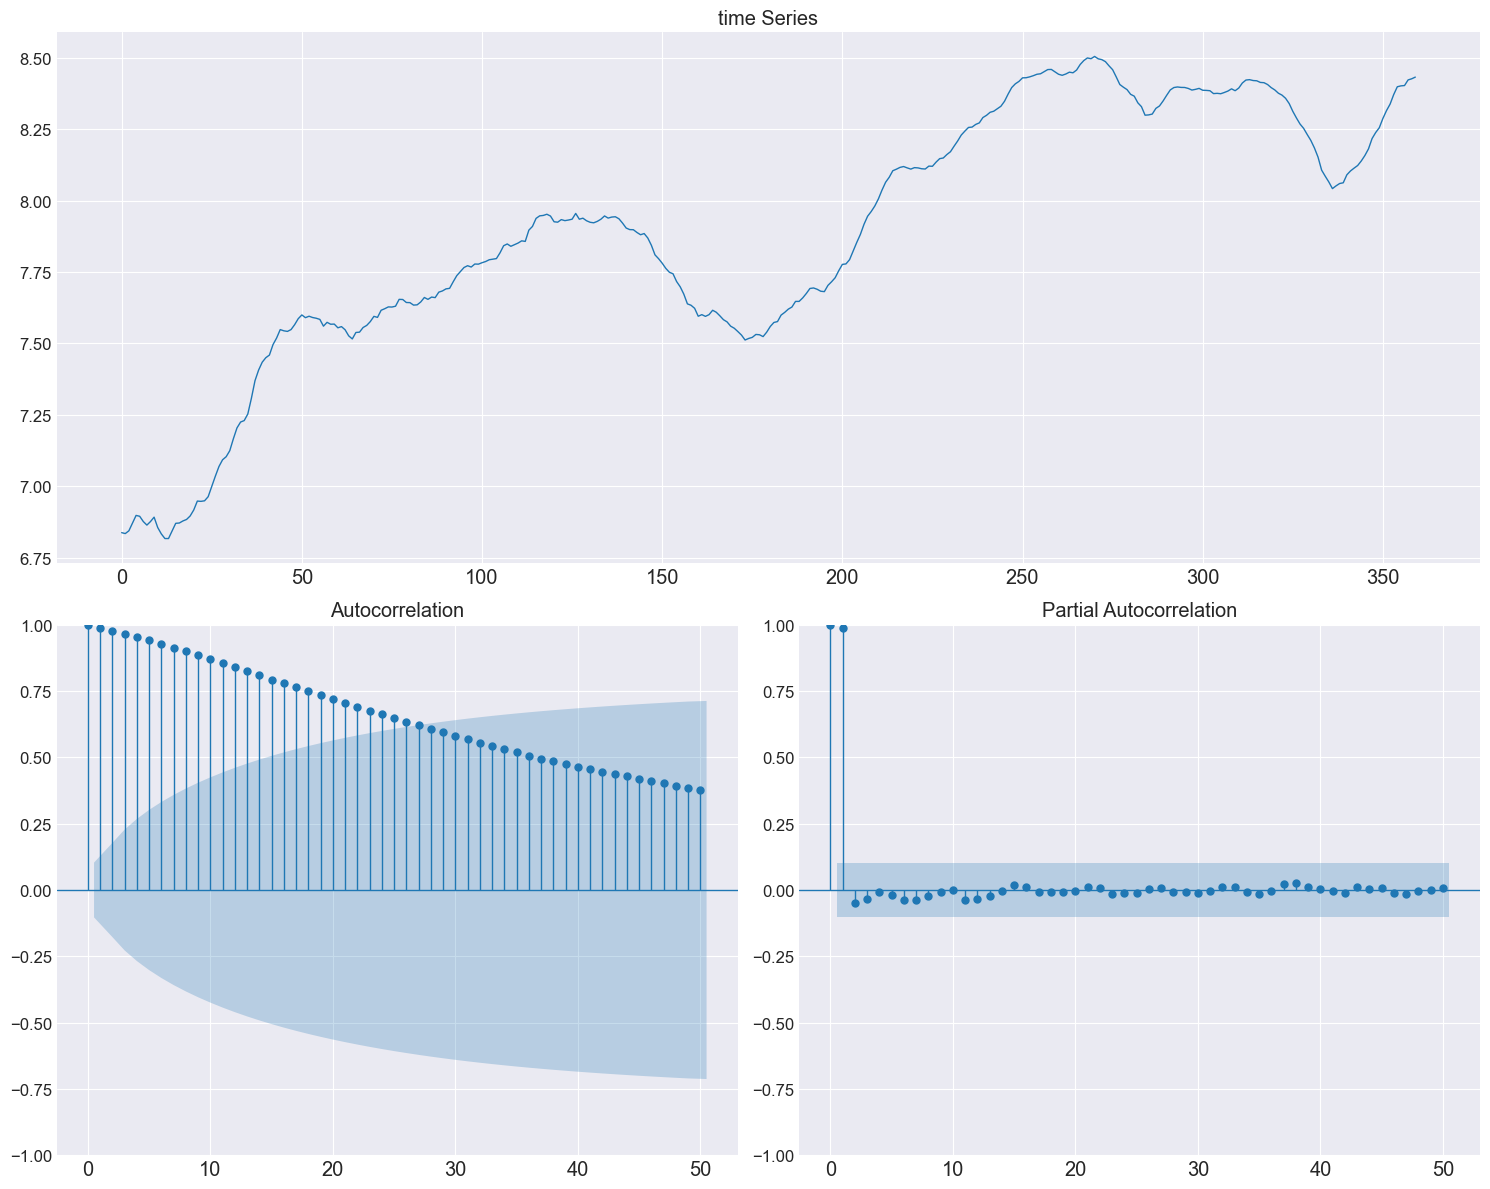

In [14]:
train_log_df =train_df.copy()
train_log_df['traffic']=np.log(train_df['traffic'])
plotds(train_log_df.traffic,nlag=50)

In [15]:
adfuller(train_log_df['traffic'].to_numpy())[1] # >0-value>>0.05

0.14115300409434967

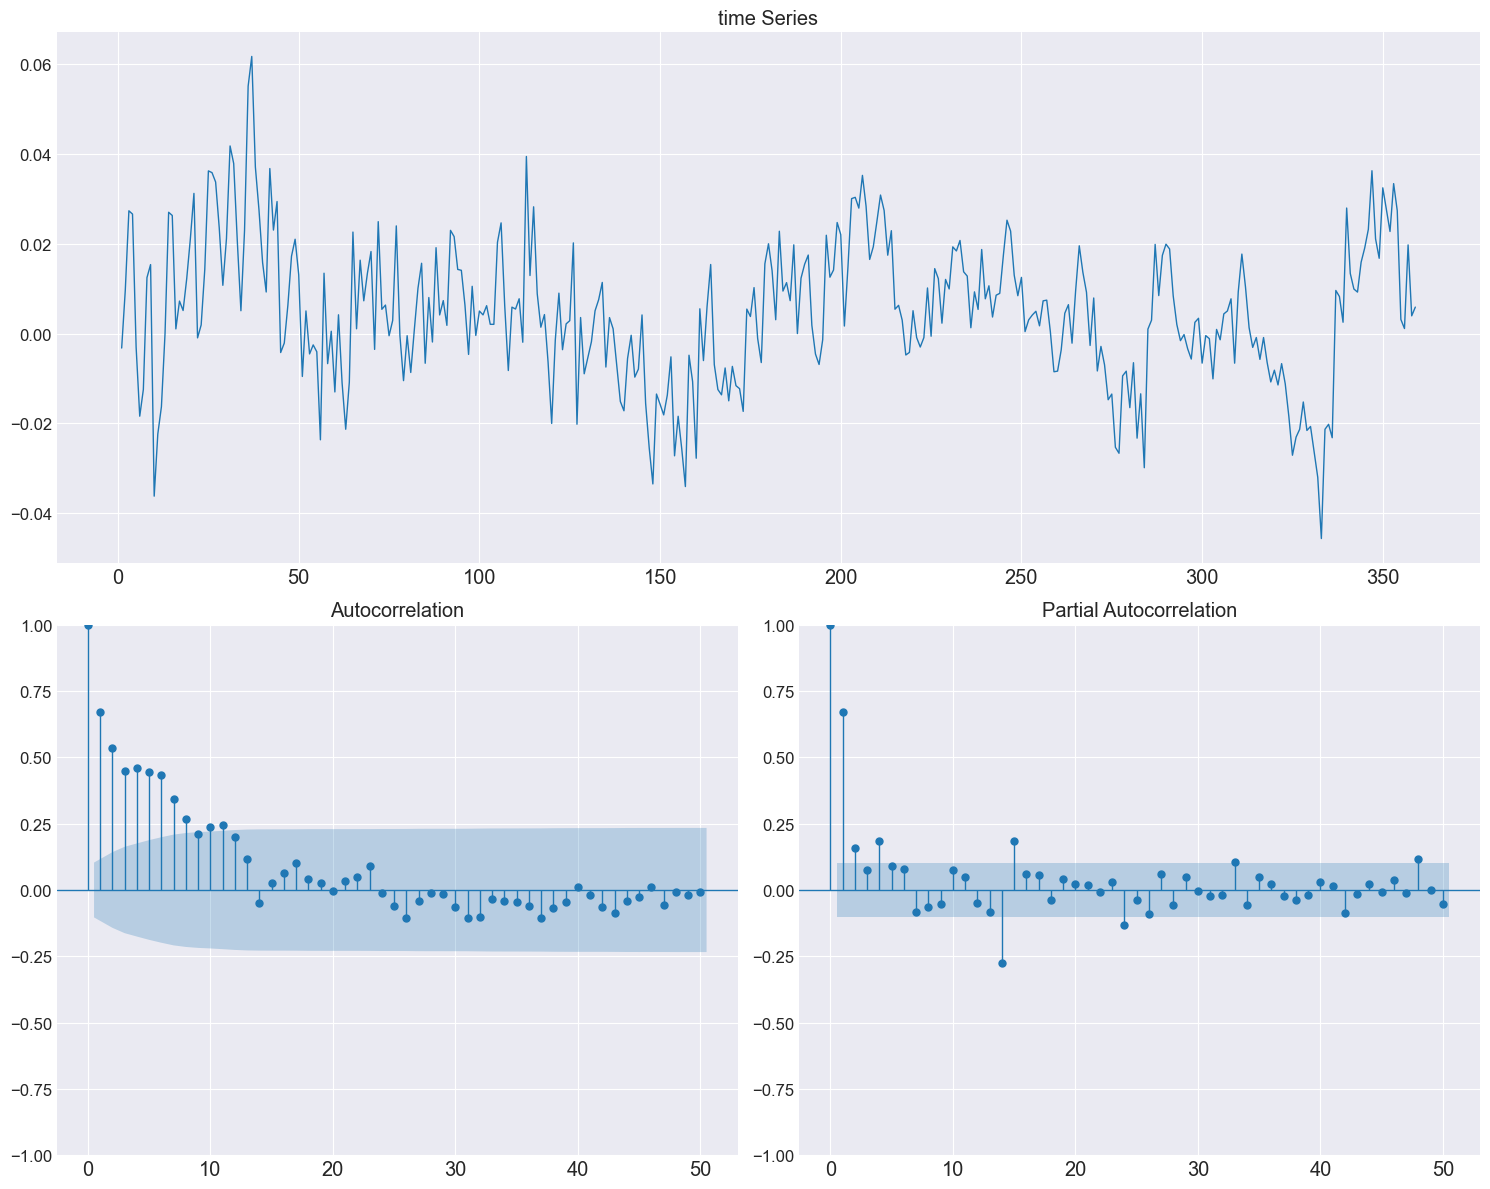

In [16]:
diff_train_df =train_log_df.diff().dropna()
plotds(diff_train_df.traffic,nlag=50)

In [17]:
adfuller(diff_train_df.traffic.to_numpy())[1]

0.010317993962745502

In [18]:
data_df['diff']=data_df['traffic'].diff()
data_df.head(20)

,traffic,diff
0,932,NaN
1,929,-3.0
2,938,9.0
3,964,26.0
4,990,26.0
5,987,-3.0
6,969,-18.0
7,957,-12.0
8,969,12.0
9,984,15.0


In [19]:
model = ARIMA(diff_train_df,order=(5,1,0))

res = model.fit()
res.summary()

C:\Users\duasp\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\duasp\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\duasp\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\duasp\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                traffic   No. Observations:                  359
Model:                 ARIMA(5, 1, 0)   Log Likelihood                1091.847
Date:                Mon, 28 Oct 2024   AIC                          -2171.695
Time:                        09:48:29   BIC                          -2148.412
Sample:                             0   HQIC                         -2162.435
                                - 359                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4571      0.054     -8.484      0.000      -0.563      -0.351
ar.L2         -0.3274      0.060     -5.420      0.000      -0.446      -0.209
ar.L3         -0.3266      0.052     -6.240      0.000      -0.429      -0.224
ar.L4         -0.1852      0.054     -3.400      0.001      -0.292      -0.078
ar.L5         -0.1201      0.050     -2.396      0.017      -0.218      -0.022
sigma2         0.0001   8.41e-06     15.598      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                16.70
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

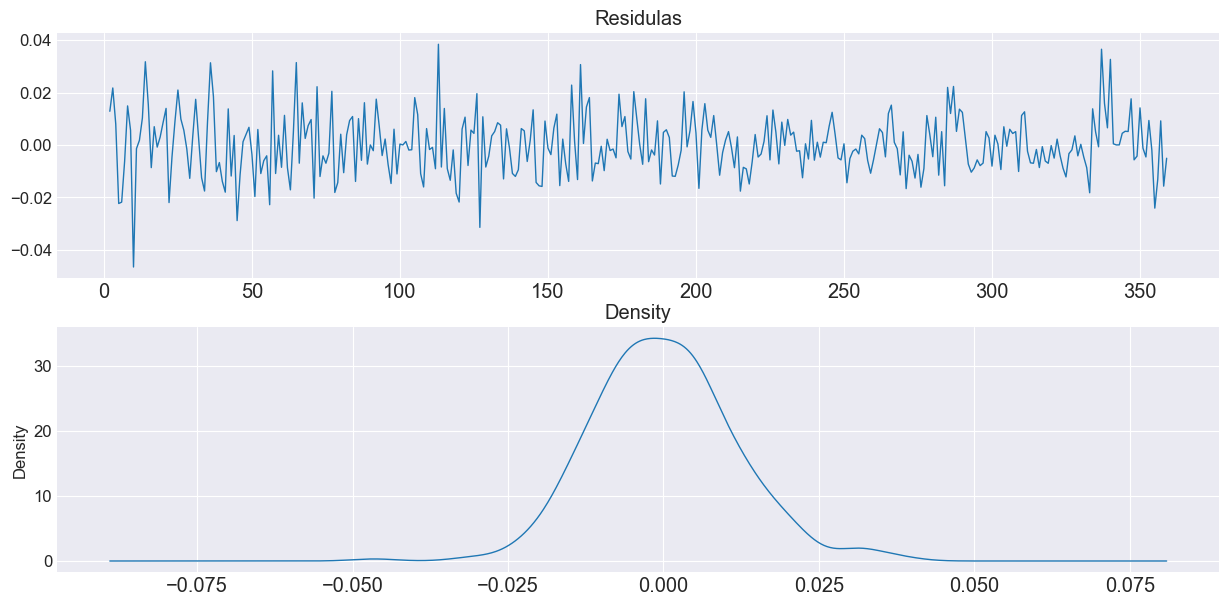

In [20]:
fig = plt.figure()
ax = fig.add_axes(211)
residuals = res.resid[1:]
residuals.plot(title ='Residulas',ax=ax)

ax =fig.add_axes(212)
residuals.plot(title='Density',kind='kde',ax=ax);

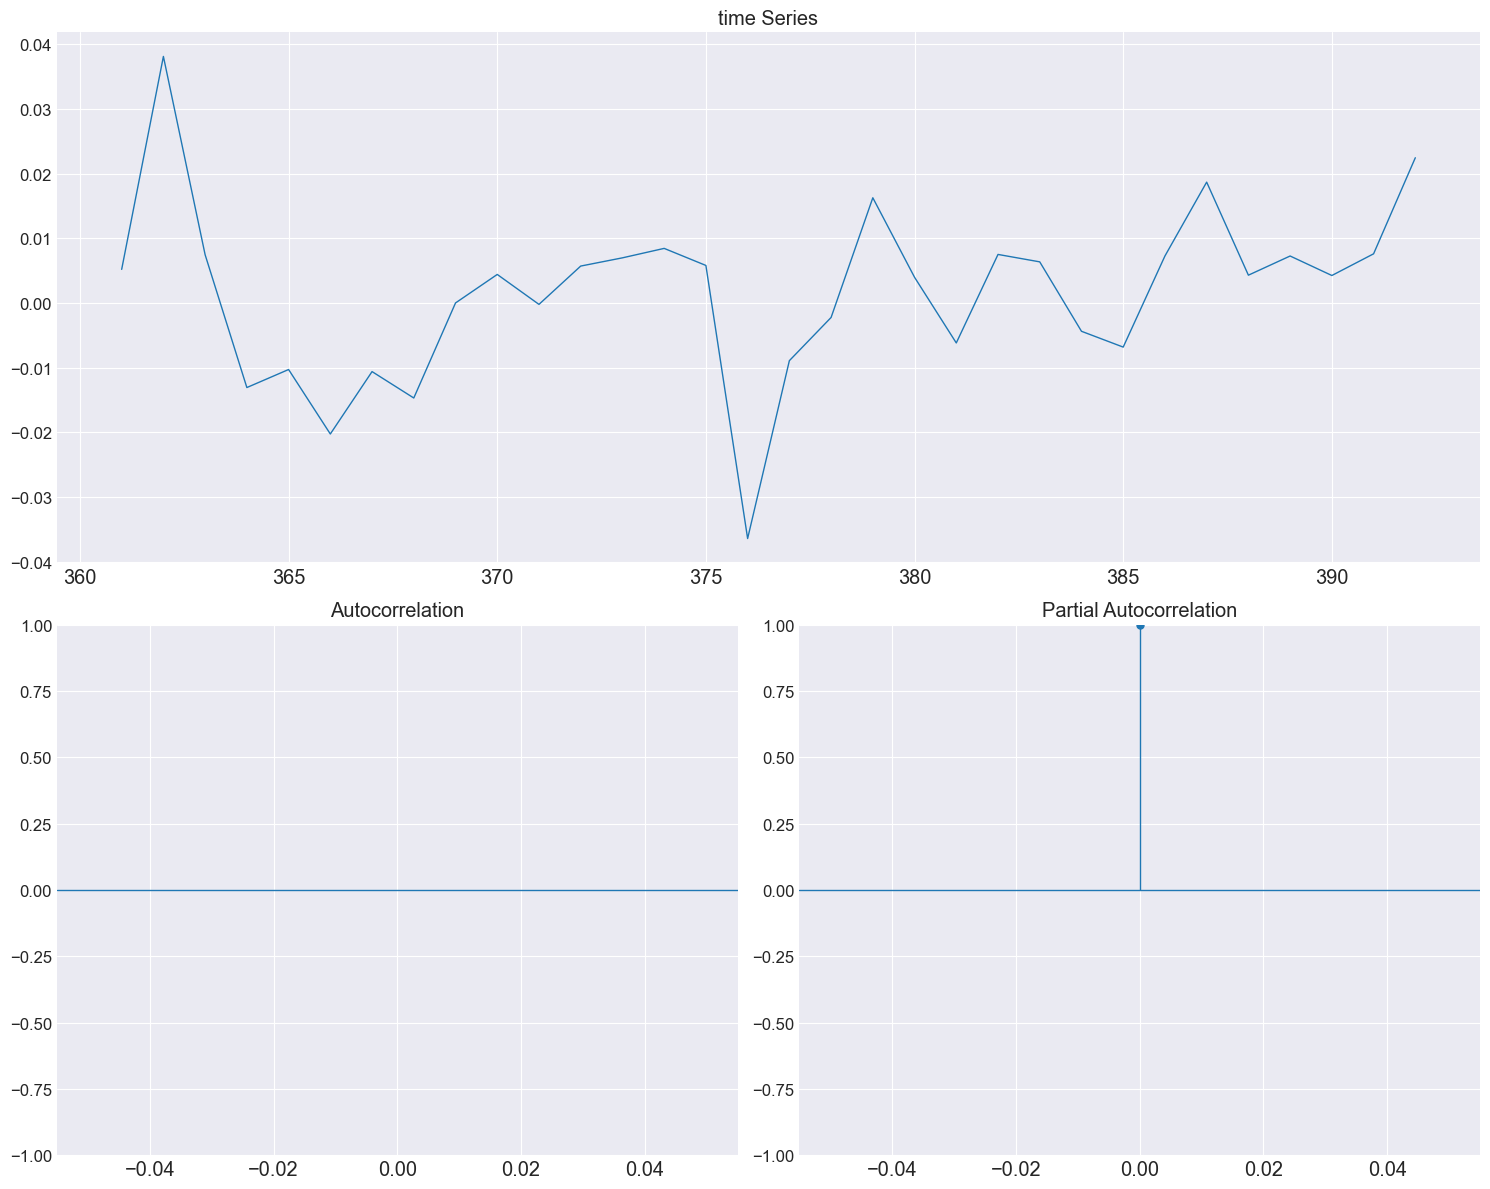

In [21]:
test_log_df = test_df.copy()
test_log_df['traffic']=np.log(test_log_df['traffic'])
test_log_df['traffic']=test_log_df['traffic'].diff().dropna()
plotds(test_log_df.traffic,nlag=15)

C:\Users\duasp\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\duasp\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

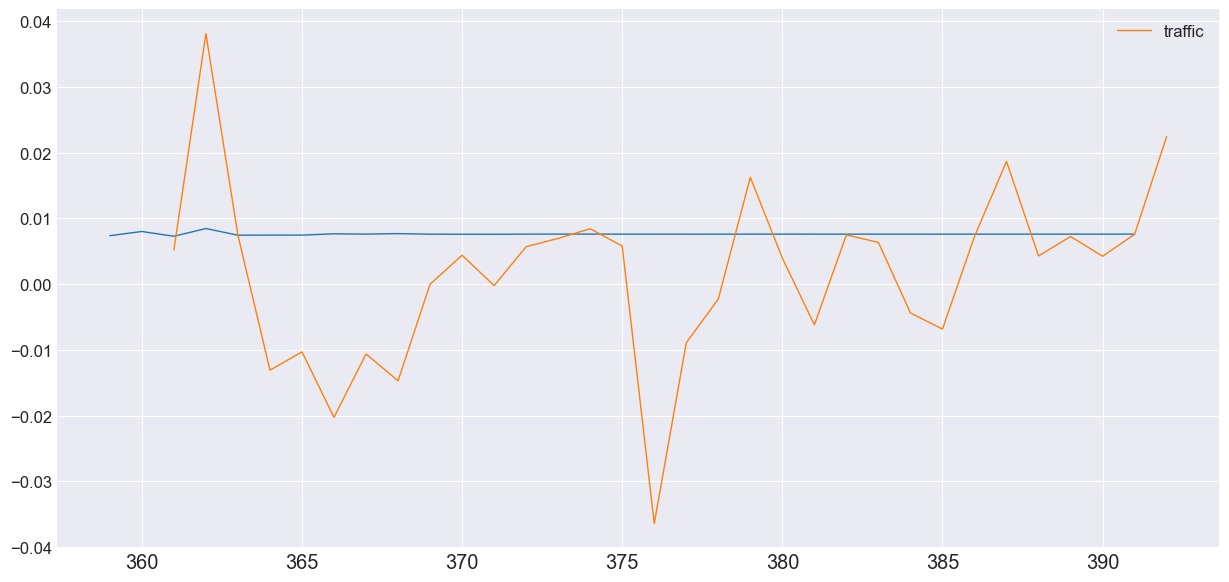

In [48]:
test_pred =res.forecast(test_log_df.shape[0])
# ax=train_log_df.plot()
ax=test_pred.plot()
test_log_df.plot(ax=ax)